In [ ]:
import opdata
import numpy as np
import cv2 as cv
import sys
import dataProc
sys.path.append('./preprocess/')
sys.path.append('./analy/')
import preprocess.visualize as visualize
import preprocess.ecg as Ecg
import preprocess.pseudoEcg as pseudoEcg
import analysis
import matplotlib.pyplot as plt
import resUnet3d
import analy.activation as activation

# Optical mapping

In [ ]:
import importlib
importlib.reload(opdata)

In [3]:
path = '/mnt/Jalife/ExperimentData/20190731-2/op/C001H001S0003/'
op = opdata.OpVmem(path, (256, 256), (0, 0, 256, 256), end=2000)

In [4]:
! mkdir /mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3

mkdir: cannot create directory '/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3': File exists


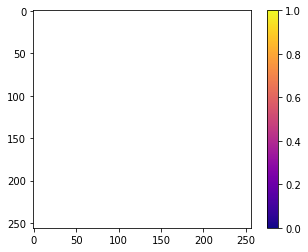

In [6]:
raw_vmem_video = visualize.makeMovie(op.vmem, 'plasma', 30)
raw_vmem_video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3/1_raw.mp4')

In [5]:
op.spatialFilter(3)
#op.temporalFilter(5)
op.highPassFilter(2, 3)

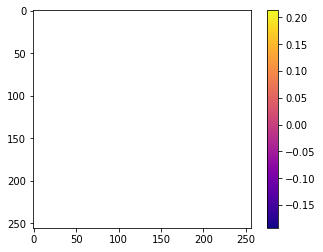

In [8]:
filtered_vmem_video = visualize.makeMovie(op.vmem, 'plasma', 30)
filtered_vmem_video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3/1_filtered.mp4')

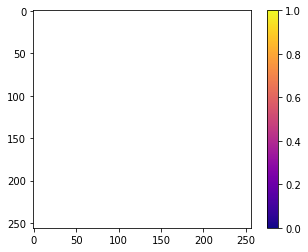

In [9]:
pxnormed_vmem = dataProc.channelNormalize(op.vmem)
video = visualize.makeMovie(pxnormed_vmem, 'plasma', 30)
video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3/1_pxnormed.mp4')

# ECG

In [ ]:
importlib.reload(Ecg)

In [ ]:
ecg_raw = Ecg.load('/mnt/Jalife/ExperimentData/20190731-2/ecg/C001H001S0003/20190731174807258.csv', 0, 2000,1,26)
fig_ecg_raw = visualize.plot(ecg_raw)
fig_ecg_raw

In [ ]:
ecg = Ecg.filterEcg(ecg_raw, 1000, 150, 3, 2, 3, (50, 100), (3, 3))

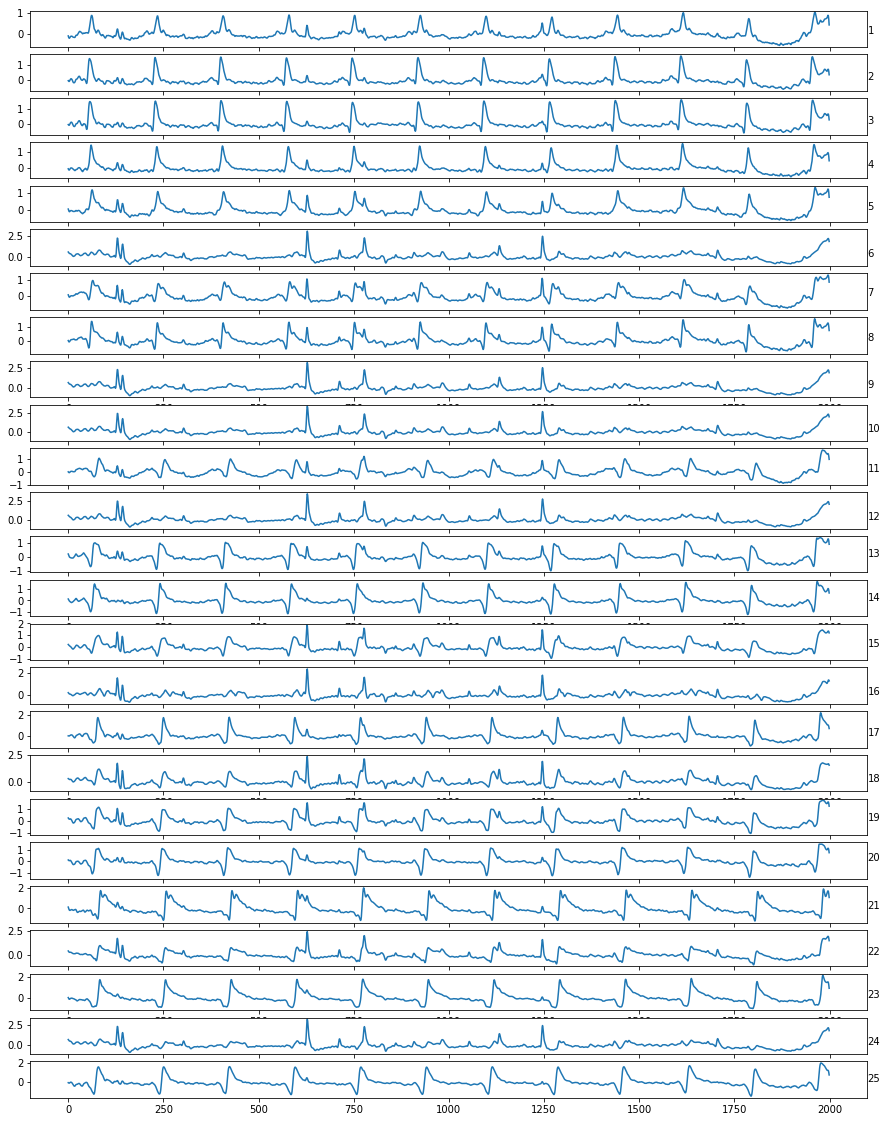

In [13]:
fig_ecg = visualize.plot(ecg)
fig_ecg

In [ ]:
ecg_valid = ecg[250:1750, :]
ecg_valid = dataProc.channelNormalize(ecg_valid)
fig_ecg_valid = visualize.plot(ecg_valid)
fig_ecg_valid

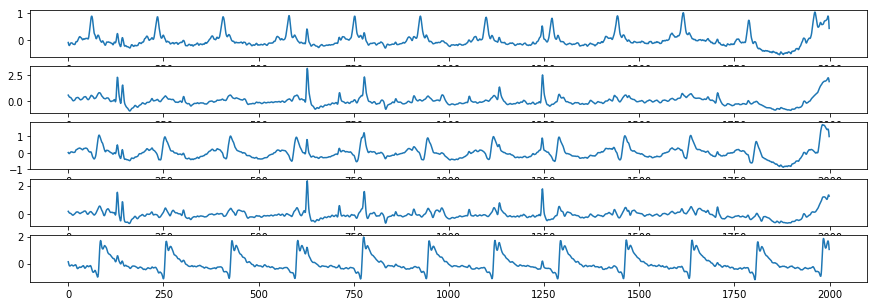

In [15]:
#1~21横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k])

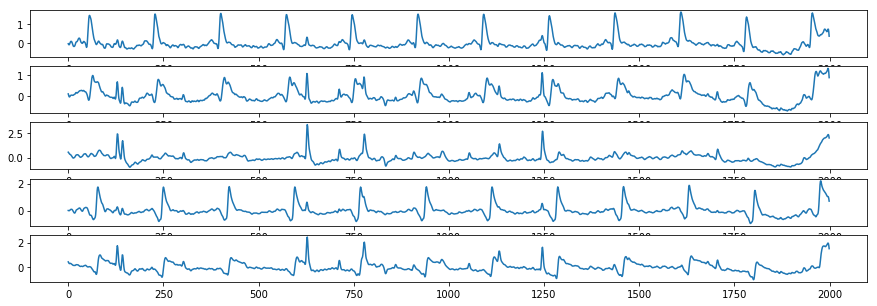

In [16]:
#2~22 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+1])

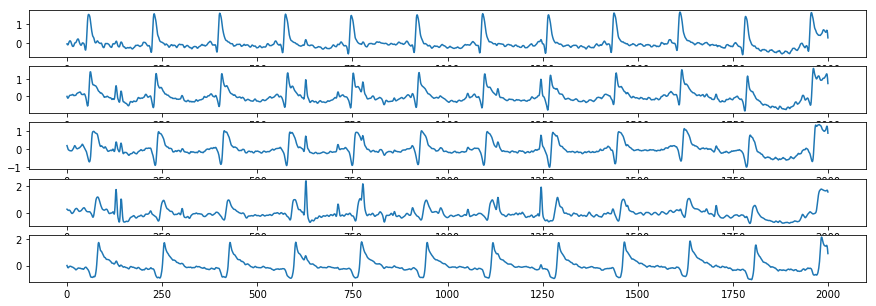

In [17]:
#3~23 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+2])

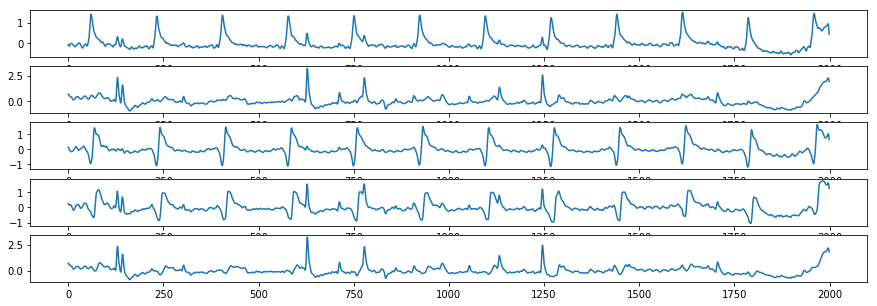

In [18]:
#4~24 横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+3])

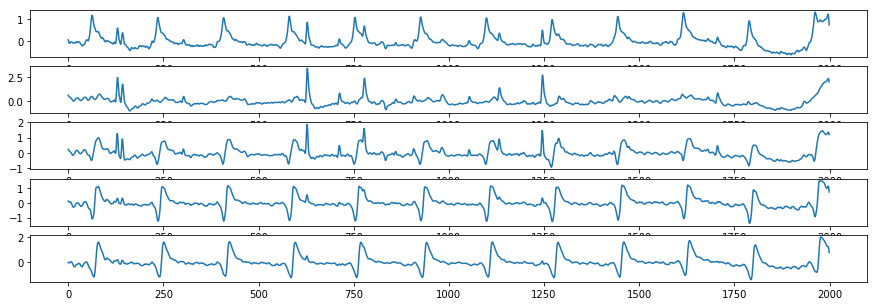

In [19]:
#5~25横比較
fig = plt.figure(figsize=(15,5))
for k in range(0,5):
    plt.subplot(5,1,k+1)
    plt.plot(ecg[:,5*k+4])

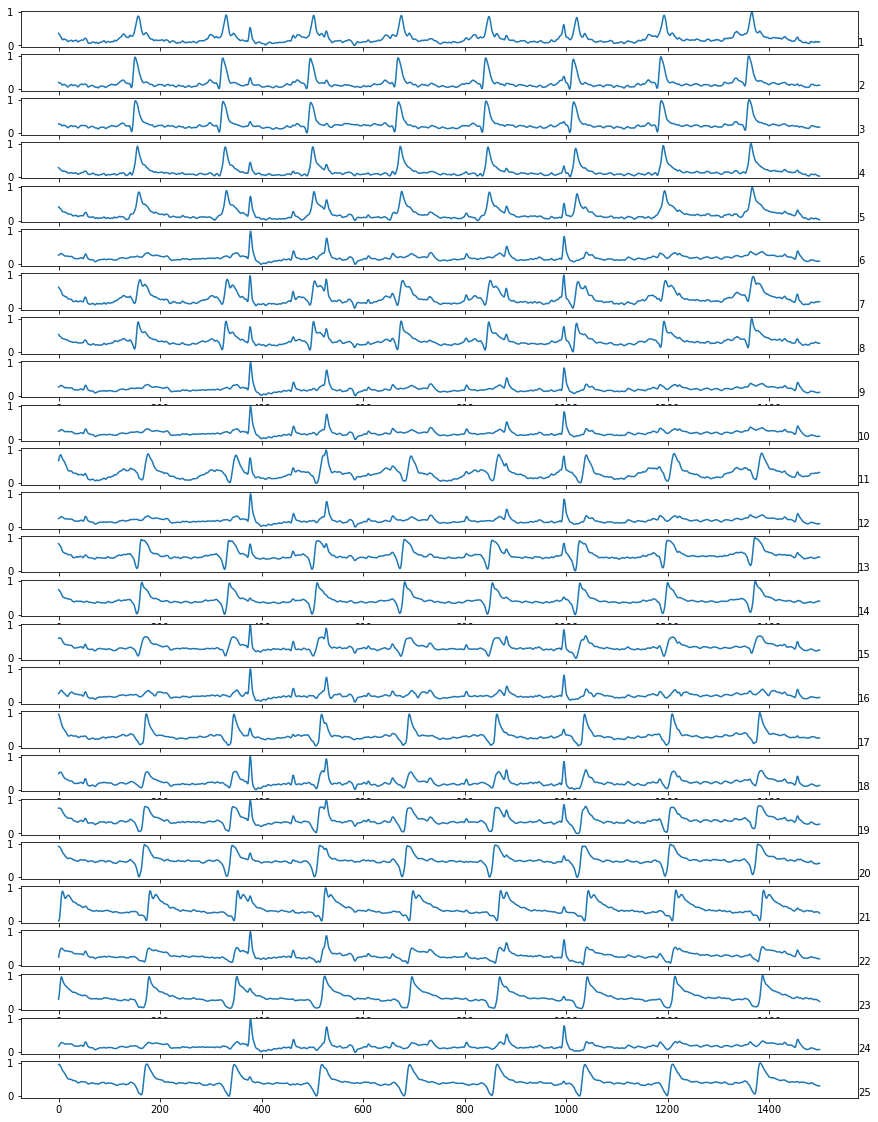

In [18]:
ecg_valid = ecg[250:1750, :]
ecg_valid = dataProc.channelNormalize(ecg_valid)
fig_ecg_valid = visualize.plot(ecg_valid)
fig_ecg_valid

# predictin

In [ ]:
elec_256 = np.array([[67,177],[99,180],[130,183],[161,183],[193,187],
[67,148],[102,147],[133,151],[165,153],[198,156],
[74,110],[105,116],[136,118],[169,122],[198,123],
[79,77],[105,87],[142,86],[171,89],[201,92],
[80,47],[112,50],[144,55],[175,57],[206,60]], np.float32)

In [ ]:
! mkdir /mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190731-2-3

In [ ]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190731-2-3/12_256', elec_256)

In [ ]:
elec_93 = np.zeros_like(elec_256)
elec_93 

In [ ]:
elec_93[:, 0] = (elec_256[:, 0] - 65)*93/(209-65)
elec_93[:, 1] = (elec_256[:, 1] - 32)*93/(202-32)

In [ ]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/electrodes/20190731-2-3/12_93', elec_93)

In [ ]:
elec_img = analysis.drawElectrodes(elec_93, mapSize=(93, 93))
plt.imshow(elec_img)

In [ ]:
ecg_maps_93 = pseudoEcg.interpolate(ecg_valid, elec_93, (93, 93))
ecg_maps_32 = dataProc.resizeSequence(ecg_maps_93, (32, 32), cv.INTER_LINEAR)
ecg_maps_32.shape

In [ ]:
ecg_blocks = dataProc.sequenceToBlocks(ecg_maps_32, 320, 16)
ecg_blocks.shape

In [ ]:
netg = resUnet3d.getModel(320, 32, 32, 1, 4, 32, 16, 'sigmoid')
netg.summary()

In [ ]:
model_dir = '/mnt/Omer/Project/07.DeepElectrodeMapping/model/20190710_1/netg.h5'
netg.load_weights(model_dir)

In [ ]:
pred_blocks = netg.predict(ecg_blocks)
pred_blocks.shape

In [ ]:
pred = dataProc.blocksToSequence(pred_blocks, 16)
pred.shape

In [ ]:
video = visualize.makeMovie(pred, 'plasma', 30)
video.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/exp_analysis/20190731-2-3/12_pred.mp4')

In [ ]:
np.save('/mnt/Omer/Project/07.DeepElectrodeMapping/kato/prediction/exp/20190731_2_3/vm',pred)

In [ ]:
ecg_actv = Ecg.filterEcg(ecg_raw, 1000, 30, 3, 2, 3, (50, 100), (3, 3))[250+16: 250+16+1440]
ecg_actv = dataProc.channelNormalize(ecg_actv)

In [ ]:
vmem_actv = activation.VmemFromActivation(ecg_actv, elec_93, (93, 93), vmem_min=0, vmem_max=1, prominence=0.4)

In [ ]:
 plt.figure(figsize=(15,180))
fig_actv = visualize.plot(ecg_actv)

for  k in range(0,25):
    plt.subplot(75, 1, 3*k+1)
    plt.plot(ecg_actv[:, k])
    plt.vlines(vmem_actv.activation_time[k],0,1,color='r')
    plt.title('%d-ECG' % (k+1))

    plt.subplot(75, 1, 3*k+2)
    plt.plot(pred[0:1440, int(elec_93[k,0]*32/93), int(elec_93[k,1]*32/93), 0])
    plt.title('%d-Vmem_pre' % (k+1))
    
    plt.subplot(75, 1, 3*k+3)
    plt.plot(op.vmem[250+16: 250+16+1440, int(elec_256[k,0]), int(elec_256[k,1]), 0])
    plt.title('%d-Vmem_rec' % (k+1))

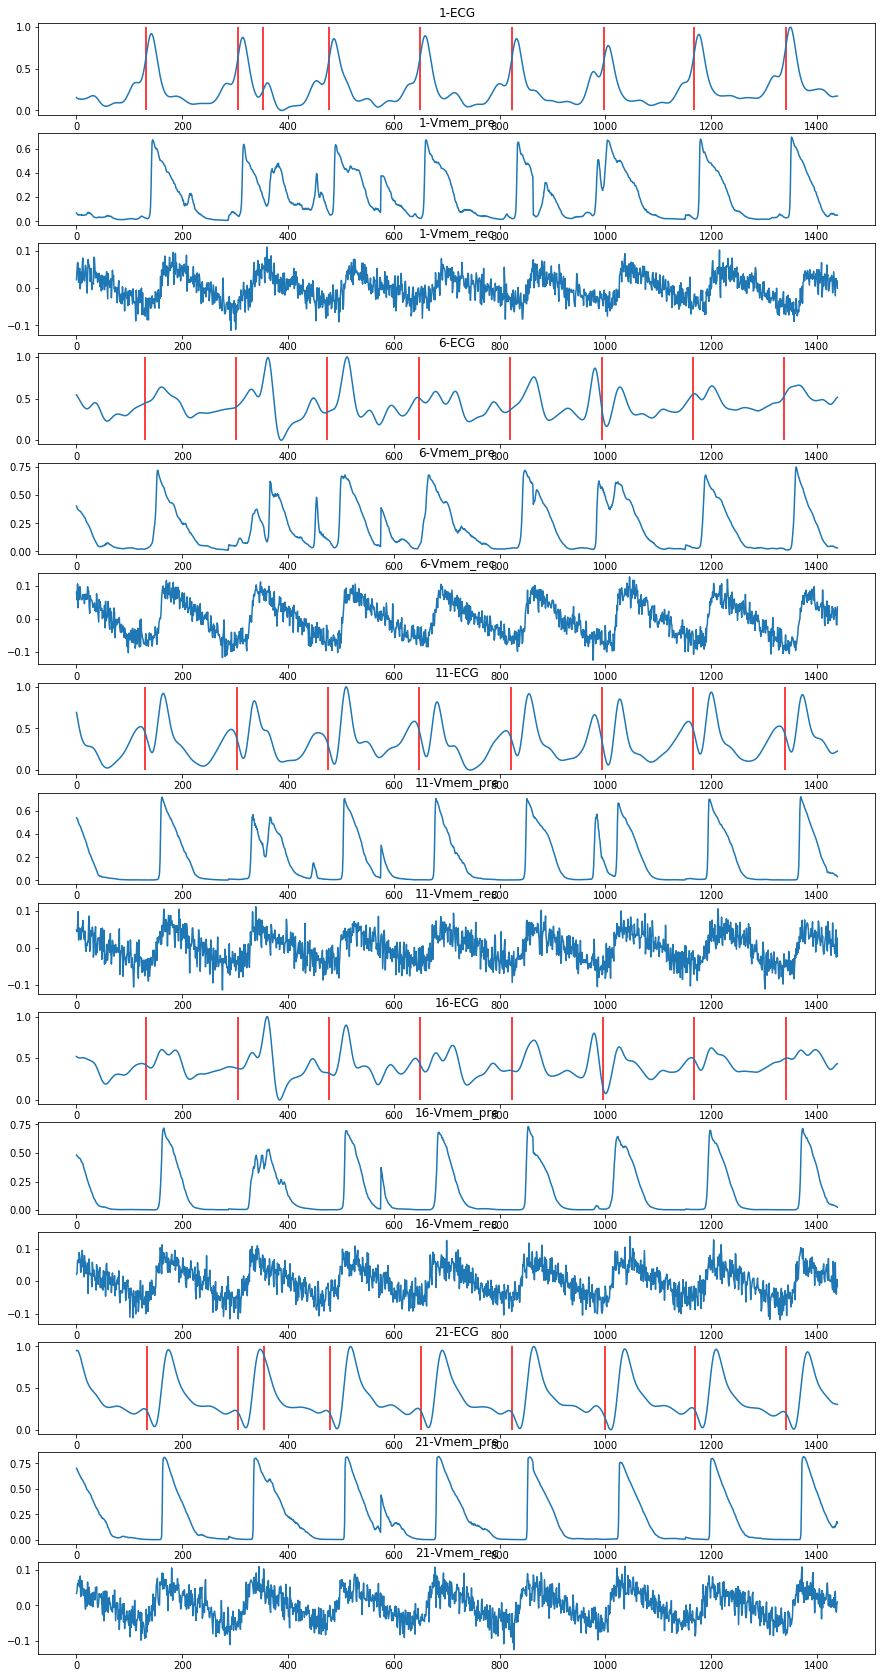

In [31]:
 plt.figure(figsize=(15,30))
fig_actv = visualize.plot(ecg_actv)

for  k in range(0,5):
    plt.subplot(15, 1, 3*k+1)
    plt.plot(ecg_actv[:, k*5])
    plt.vlines(vmem_actv.activation_time[k],0,1,color='r')
    plt.title('%d-ECG' % (5*k+1))

    plt.subplot(15, 1, 3*k+2)
    plt.plot(pred[0:1440, int(elec_93[k*5,0]*32/93), int(elec_93[k*5,1]*32/93), 0])
    plt.title('%d-Vmem_pre' % (5*k+1))
    
    plt.subplot(15, 1, 3*k+3)
    plt.plot(op.vmem[250+16: 250+16+1440, int(elec_256[k*5,0]), int(elec_256[k*5,1]), 0])
    plt.title('%d-Vmem_rec' % (5*k+1))